In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
check = session.query(Measurement)
print(check)

SELECT measurement.id AS measurement_id, measurement.station AS measurement_station, measurement.date AS measurement_date, measurement.prcp AS measurement_prcp, measurement.tobs AS measurement_tobs 
FROM measurement


In [11]:
check2 = session.query(Station)
print(check2)

SELECT station.id AS station_id, station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM station


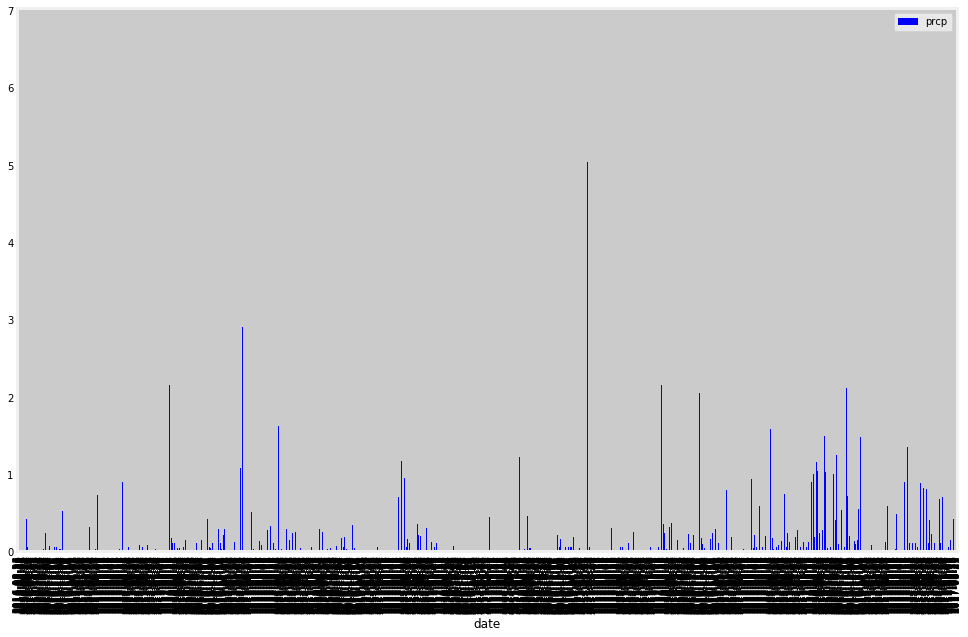

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores
ayear = session.query(Measurement.id, Measurement.station, Measurement.date, 
                      Measurement.prcp, Measurement.tobs).filter(Measurement.date > "2016-08-23").all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(ayear, columns=["id","station","date","prcp","tobs"])
df.set_index("id", inplace=True, )
df.sort_values(by="date", ascending=False)
df.head()
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

df.plot(kind='bar',x='date',y='prcp',color='blue',figsize=(15, 10))
plt.xlabel("date")
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp,tobs
count,2015.000000,2223.000000
mean,0.176462,74.578947
std,0.460288,4.612232
min,0.000000,58.000000
25%,0.000000,71.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
row2 = session.query(Station)
#print(row2)
#for row in session.query(Station.name):
#   print(row)
counting = session.query(Station.name).count()
counting

9

In [15]:
row2 = session.query(Station)
print(row2)

SELECT station.id AS station_id, station.station AS station_station, station.name AS station_name, station.latitude AS station_latitude, station.longitude AS station_longitude, station.elevation AS station_elevation 
FROM station


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

#for row in session.query(Station.station):
#   print(row)
#counting = session.query(Station.station).count()

counting = session.query(Measurement.station, func.count(Measurement.station)).group_by("station")
for row in counting:
    print(row)

('USC00511918', 1979)
('USC00513117', 2709)
('USC00514830', 2202)
('USC00516128', 2612)
('USC00517948', 1372)
('USC00518838', 511)
('USC00519281', 2772)
('USC00519397', 2724)
('USC00519523', 2669)


In [17]:
inspector = inspect(engine)
inspector.get_table_names()
measurement_columns = inspector.get_columns("measurement")
station_columns = inspector.get_columns("station")
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [18]:
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
calc = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281")
for row in calc:
    print(row)


(54.0, 85.0, 71.66378066378067)


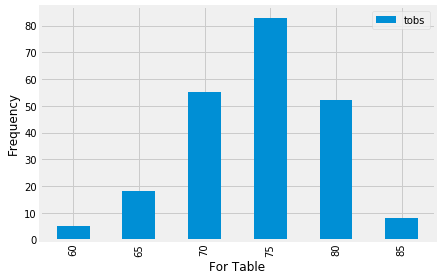

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
table = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.station == "USC00519281",Measurement.date > "2016-8-23")
#for row in table:
#   print(row)
df = pd.DataFrame(table)
bins=[0,60,65,70,75,80,85]
df["rep"] = pd.cut(df["tobs"], bins)
#df.head()
df2=df.groupby(["rep"]).count()
df2["For Table"]= [60,65,70,75,80,85]
#df2.head()
df3 = df2.plot.bar(x="For Table", y="tobs")
plt.tight_layout()
df3.set_ylabel("Frequency")
plt.show()


![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.   
calc2 = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs),func.max(Measurement.tobs)-func.min(Measurement.tobs)).\
        filter(Measurement.date >= "2017-08-09").filter(Measurement.date <= "2017-08-23").all()
print(calc2)


[(70.0, 78.64406779661017, 85.0, 15.0)]


Text(0, 0.5, 'Temp(F)')

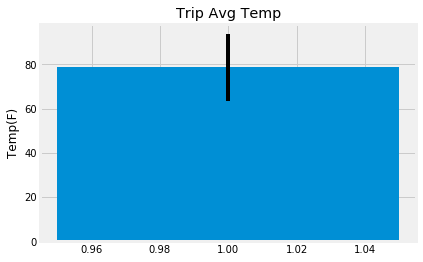

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df2 = pd.DataFrame(calc2, columns=["min","avg","max","max-min"])
#df2
plt.bar(x=1,height=df2["avg"],width=0.1,yerr=df2["max-min"])
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")

In [49]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
meas_que = session.query(Measurement.id, Measurement.station, Measurement.date, 
                      Measurement.prcp, Measurement.tobs).filter(Measurement.date > "2017-08-09").all()
meas_que_df = pd.DataFrame(meas_que, columns=["id","station","date","prcp","tobs"])
station_que = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all()
station_que_df = pd.DataFrame(station_que, columns=["id","station","name","lat","lon","ele"])
merged_df = meas_que_df.merge(station_que_df, on="station")
merged_df_sorted = merged_df.sort_values(by="tobs",ascending=False)
merged_df_sorted_2 = merged_df_sorted.groupby("station")["tobs"].sum()
merged_df_sorted_2

station
USC00514830     964.0
USC00516128    1046.0
USC00519281     462.0
USC00519397     961.0
USC00519523     975.0
Name: tobs, dtype: float64

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


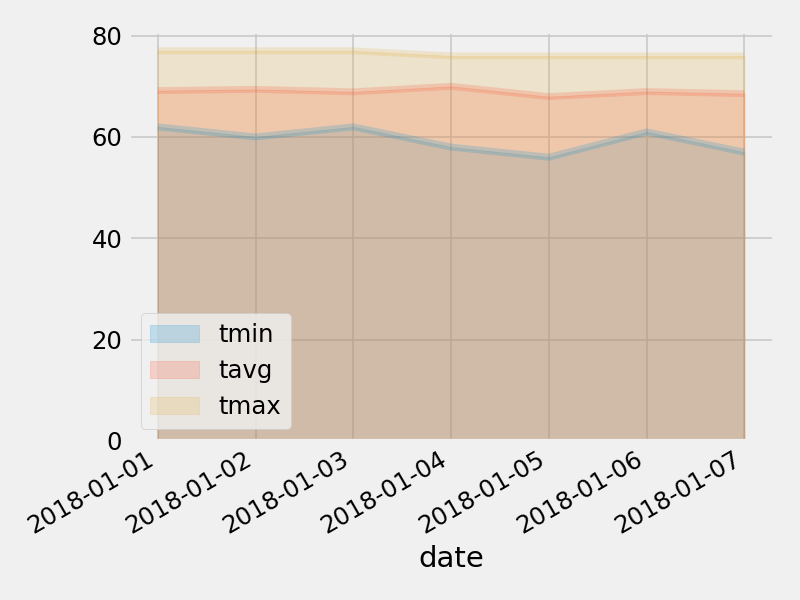

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
